---
# Predictive Modeling 
# Author: Adefemi Abimbola
---


In [160]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import ast
import shap
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [79]:
#path to each cleaned data set unique to your system
review_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/reviews.csv'
business_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/business.csv'
user_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/user.csv'
checkin_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/checkin.csv'
tip_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/tip.csv'

In [80]:
# read the data
review = pd.read_csv(review_path)
business = pd.read_csv(business_path)
user = pd.read_csv(user_path)
checkin = pd.read_csv(checkin_path)
tip = pd.read_csv(tip_path)

In [81]:
# get the shape of each dataset
print("Review shape:", review.shape)
print("Business shape:", business.shape)
print("User shape:", user.shape)
print("Checkin shape:", checkin.shape)
print("Tip shape:", tip.shape)

Review shape: (1987897, 9)
Business shape: (150346, 12)
User shape: (1987897, 7)
Checkin shape: (131930, 2)
Tip shape: (908915, 5)


---
- Baseline Models(linear Regression & Decision tree)
    - Goal: Predicting business star rating using simple features
---

In [83]:
def extract_attribute(attr_str, key):
    try:
        attr_dict = ast.literal_eval(attr_str)
        return attr_dict.get(key, None)
    except:
        return None


In [84]:
def extract_parking_type(attr_str, parking_type):
    try:
        attr_dict = ast.literal_eval(attr_str)
        parking_str = attr_dict.get('BusinessParking')
        parking_dict = ast.literal_eval(parking_str) if parking_str else {}
        return parking_dict.get(parking_type, None)
    except:
        return None

In [87]:
def simplify_category(cat_string):
    if not isinstance(cat_string, str):
        return 'Other'
    
    cat_string = cat_string.lower()

    if 'restaurant' in cat_string or 'food' in cat_string:
        return 'Restaurant'
    elif 'shopping' in cat_string or 'store' in cat_string:
        return 'Retail'
    elif 'health' in cat_string or 'medical' in cat_string or 'nutritionist' in cat_string:
        return 'Health'
    elif 'beauty' in cat_string or 'spa' in cat_string or 'salon' in cat_string:
        return 'Beauty'
    elif 'bar' in cat_string or 'nightlife' in cat_string or 'club' in cat_string:
        return 'Nightlife'
    elif 'education' in cat_string or 'school' in cat_string:
        return 'Education'
    elif 'service' in cat_string or 'notary' in cat_string:
        return 'Professional Services'
    elif 'public service' in cat_string or 'government' in cat_string:
        return 'Government'
    elif 'automotive' in cat_string or 'car' in cat_string or 'mechanic' in cat_string or 'tire' in cat_string:
        return 'Automotive'
    elif 'gym' in cat_string or 'fitness' in cat_string or 'yoga' in cat_string or 'active life' in cat_string:
        return 'Fitness'
    elif 'pets' in cat_string or 'animal' in cat_string or 'veterinary' in cat_string:
        return 'Veterinary'
    elif 'hotel' in cat_string or 'lodging' in cat_string or 'travel' in cat_string:
        return 'Travel'
    elif 'church' in cat_string or 'temple' in cat_string or 'synagogue' in cat_string or 'place of worship' in cat_string:
        return 'Religious'
    elif 'movie' in cat_string or 'cinema' in cat_string or 'theater' in cat_string or 'art' in cat_string or 'museum' in cat_string or 'entertainment' in cat_string:
        return 'Entertainment'
    elif 'media' in cat_string or 'news' in cat_string or 'radio' in cat_string or 'television' in cat_string:
        return 'Media/Station'
    else:
        return 'Other'


In [82]:
# aggregate the datasets according to the business_id
review_agg = review.groupby('business_id').agg({
    'stars': 'mean',
    'text': lambda x: x.str.len().mean(),  # average length
    'review_id': 'count'  # number of reviews
}).rename(columns={'stars': 'avg_review_rating', 'text': 'avg_review_length', 'review_id': 'num_reviews'})


In [85]:
business = business[['business_id', 'name', 'stars', 'review_count', 'categories', 'attributes', 'is_open']]

business['WiFi'] = business['attributes'].apply(lambda x: extract_attribute(x, 'WiFi'))
business['credit_cards'] = business['attributes'].apply(lambda x: extract_attribute(x, 'BusinessAcceptsCreditCards'))
business['bike_parking'] = business['attributes'].apply(lambda x: extract_attribute(x, 'BikeParking'))
business['parking_garage'] = business['attributes'].apply(lambda x: extract_parking_type(x, 'garage'))
business['parking_lot'] = business['attributes'].apply(lambda x: extract_parking_type(x, 'lot'))
business['parking_street'] = business['attributes'].apply(lambda x: extract_parking_type(x, 'street'))

# Encode WiFi
business['WiFi'] = business['WiFi'].map({'free': 2, 'paid': 1, 'no': 0, 'None': 0})


In [86]:
# merge the business and review dataframes
baseline_df = business.merge(review_agg, on='business_id', how='left')

# cleaning the baseline_df
baseline_df = baseline_df.dropna(subset=['avg_review_rating', 'avg_review_length', 'num_reviews'])

# simplifying the categories
baseline_df['category_simple'] = baseline_df['categories'].apply(simplify_category)


In [92]:
# Drop columns we won't use
drop_cols = ['business_id', 'name', 'categories', 'attributes','is_open']
baseline_df = baseline_df.drop(columns=drop_cols)

# Define X and y
X = baseline_df.drop(columns=['stars'])
y = baseline_df['stars']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Handle missing values and encoding
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])

# Create a pipeline with preprocessing and model
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

print("🔹 Linear Regression Results:")
print("RMSE:", mean_squared_error(y_test, lr_preds, squared=False))
print("R² Score:", r2_score(y_test, lr_preds))

# Decision Tree Regressor
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', DecisionTreeRegressor(random_state=42))])

dt_pipeline.fit(X_train, y_train)
dt_preds = dt_pipeline.predict(X_test)

print("\n🔹 Decision Tree Results:")
print("RMSE:", mean_squared_error(y_test, dt_preds, squared=False))
print("R² Score:", r2_score(y_test, dt_preds))

🔹 Linear Regression Results:
RMSE: 0.24744128366567258
R² Score: 0.9344412253640886


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔹 Decision Tree Results:
RMSE: 0.3132824389152651
R² Score: 0.894910673244709


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': 'Linear Regression Predictions vs Actual Ratings'}, xlabel='stars', ylabel='dt'>

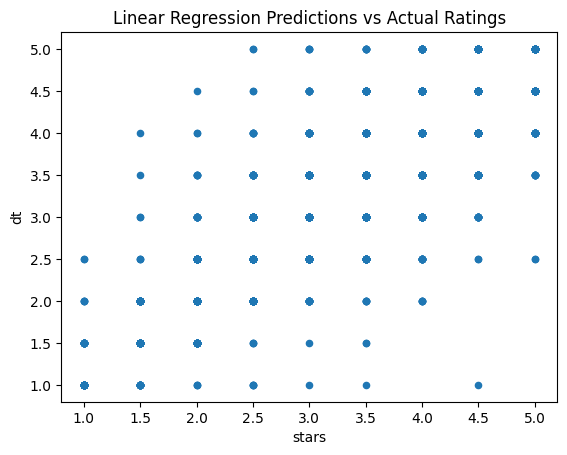

In [113]:
ex = pd.DataFrame(y_test.copy())
ex['lr'] = lr_preds
ex['dt'] = dt_preds
ex['lr'] = round(ex['lr'],1)

ex

# Plotting the results
ex.plot(x='stars', y='dt', kind='scatter', title='Linear Regression Predictions vs Actual Ratings')


In [128]:
ext = ex[ex['stars']==3.0]
ext.describe()

,stars,lr,dt
count,1078.0,1078.000000,1078.000000
mean,3.0,3.052968,3.034323
std,0.0,0.282589,0.358256
min,3.0,1.100000,1.000000
25%,3.0,2.900000,3.000000
50%,3.0,3.000000,3.000000
75%,3.0,3.200000,3.000000
max,3.0,4.900000,5.000000


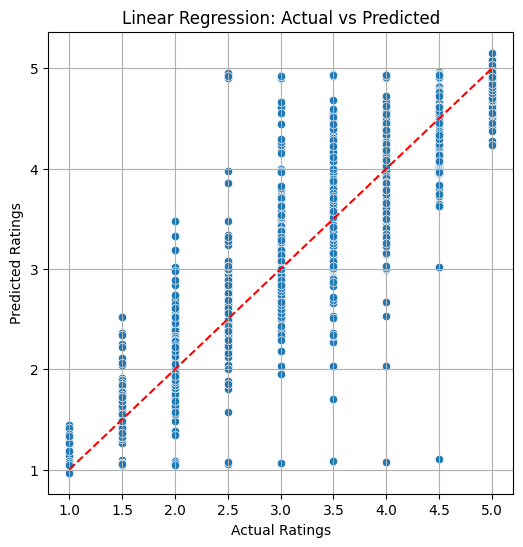

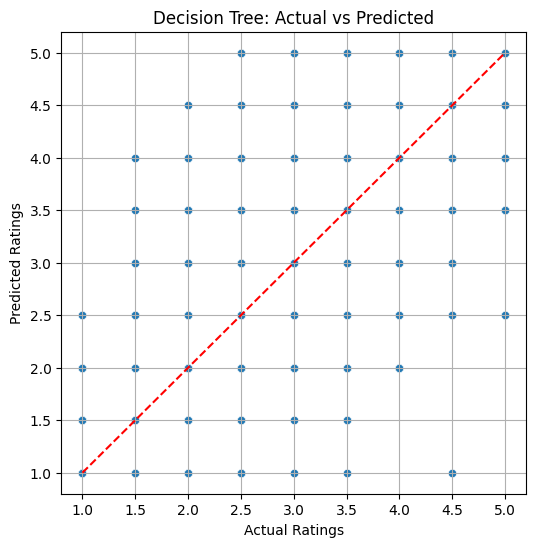

In [110]:
# Plotting function
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title(title)
    plt.grid(True)
    plt.show()

# For Linear Regression
plot_predictions(y_test, lr_preds, "Linear Regression: Actual vs Predicted")

# For Decision Tree
plot_predictions(y_test, dt_preds, "Decision Tree: Actual vs Predicted")


In [130]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

print("🔹 XGBoost Results:")
print("RMSE:", mean_squared_error(y_test, xgb_preds, squared=False))
print("R² Score:", r2_score(y_test, xgb_preds))



🔹 XGBoost Results:
RMSE: 0.22121820076594303
R² Score: 0.9476003701647432


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': 'XGBoost Predictions vs Actual Ratings'}, xlabel='stars', ylabel='xgb'>

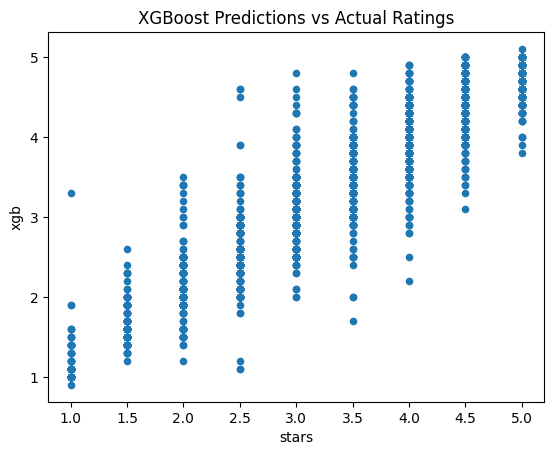

In [134]:
ex['xgb'] = xgb_preds
ex['xgb'] = round(ex['xgb'],1)
ex

ex.plot(x='stars', y='xgb', kind='scatter', title='XGBoost Predictions vs Actual Ratings')

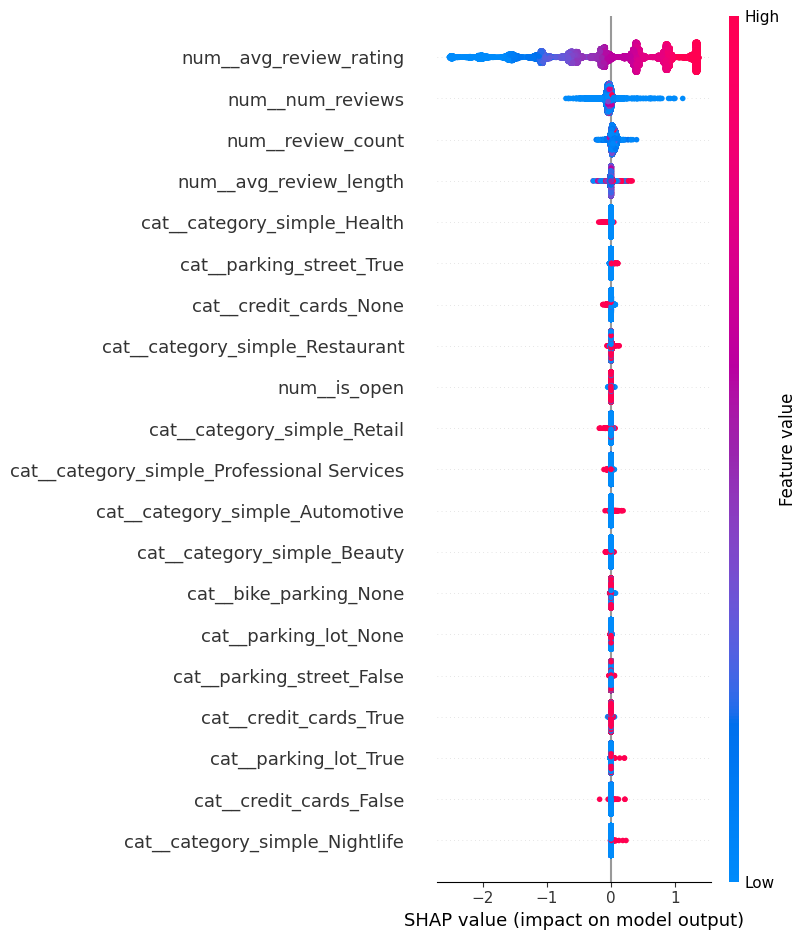

In [139]:
import shap

# Get the preprocessed data (same transformation used in pipeline)
X_transformed = preprocessor.fit_transform(X_train)

# Train raw model outside the pipeline
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_transformed, y_train)

# Use TreeExplainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_transformed)

# Summary Plot (most important features)
shap.summary_plot(shap_values, X_transformed, feature_names=preprocessor.get_feature_names_out())


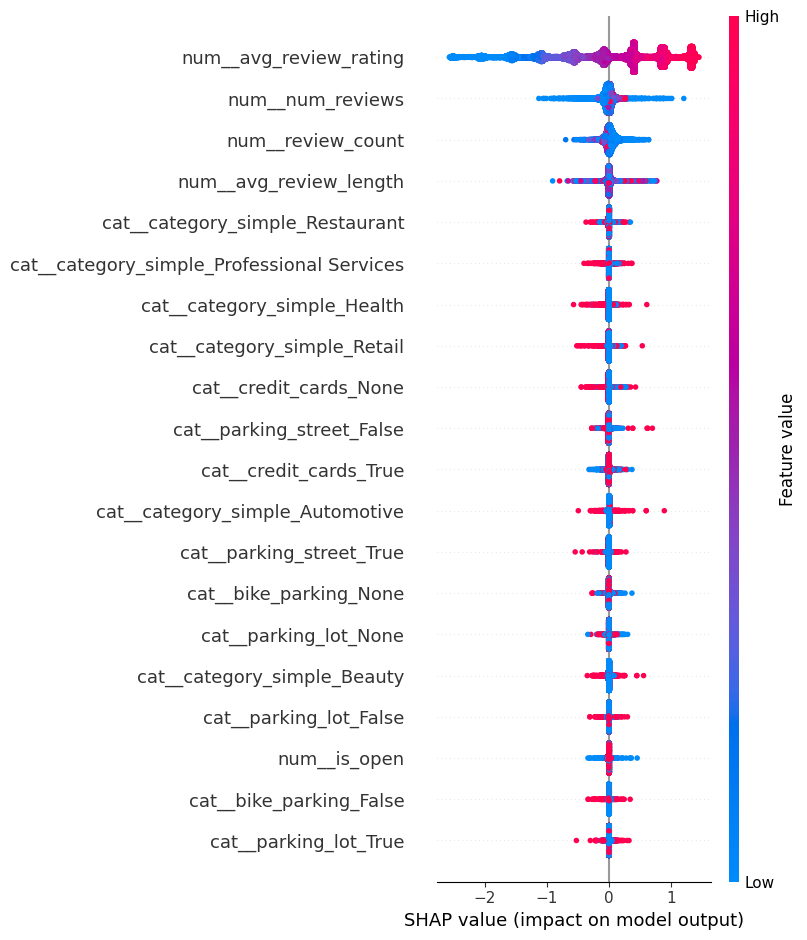

In [140]:
from sklearn.tree import DecisionTreeRegressor

# Train raw model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_transformed, y_train)

explainer_dt = shap.Explainer(dt_model)
shap_values_dt = explainer_dt(X_transformed)

shap.summary_plot(shap_values_dt, X_transformed, feature_names=preprocessor.get_feature_names_out())


In [141]:
baseline_df

,stars,review_count,is_open,WiFi,credit_cards,bike_parking,parking_garage,parking_lot,parking_street,avg_review_rating,avg_review_length,num_reviews,category_simple
0,5.0,7,0,NaN,None,None,None,None,None,4.857143,551.142857,7.0,Health
1,3.0,15,1,NaN,True,None,None,None,None,3.133333,455.666667,15.0,Professional Services
2,3.5,22,0,NaN,True,True,False,True,False,3.500000,457.291667,24.0,Retail
3,4.0,80,1,NaN,False,True,False,False,True,4.057471,558.919540,87.0,Restaurant
4,4.5,13,1,NaN,True,True,None,True,None,4.692308,501.538462,13.0,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45100,3.5,16,0,NaN,None,None,None,None,None,3.142857,1238.000000,14.0,Health
45101,1.5,6,1,NaN,None,None,None,None,None,1.000000,136.000000,1.0,Professional Services
45102,2.5,27,1,NaN,True,None,None,None,None,2.842105,459.789474,19.0,Professional Services
45103,4.0,9,1,NaN,True,True,False,False,False,3.777778,422.111111,9.0,Beauty


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_transformed, y_train)

# Get feature names and coefficients
coefs = pd.Series(lr_model.coef_, index=preprocessor.get_feature_names_out())
coefs.sort_values().plot(kind='barh', title='Linear Regression Feature Importance', figsize=(8,6))
plt.grid(True)
plt.show()


---
- classified models for business success categorization
---

In [144]:
#create a new column based on criteria
def classify_business(row):
    if row['stars'] >= 4.0 and row['review_count'] > 50:
        return 'Successful'
    elif row['stars'] >= 3.0:
        return 'Stable'
    else:
        return 'Struggling'

baseline_df['success_category'] = baseline_df.apply(classify_business, axis=1)

label_encoder = LabelEncoder()
baseline_df['success_label'] = label_encoder.fit_transform(baseline_df['success_category'])
baseline_df

,stars,review_count,is_open,WiFi,credit_cards,bike_parking,parking_garage,parking_lot,parking_street,avg_review_rating,avg_review_length,num_reviews,category_simple,success_category,success_label
0,5.0,7,0,NaN,None,None,None,None,None,4.857143,551.142857,7.0,Health,Stable,0
1,3.0,15,1,NaN,True,None,None,None,None,3.133333,455.666667,15.0,Professional Services,Stable,0
2,3.5,22,0,NaN,True,True,False,True,False,3.500000,457.291667,24.0,Retail,Stable,0
3,4.0,80,1,NaN,False,True,False,False,True,4.057471,558.919540,87.0,Restaurant,Successful,2
4,4.5,13,1,NaN,True,True,None,True,None,4.692308,501.538462,13.0,Restaurant,Stable,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45100,3.5,16,0,NaN,None,None,None,None,None,3.142857,1238.000000,14.0,Health,Stable,0
45101,1.5,6,1,NaN,None,None,None,None,None,1.000000,136.000000,1.0,Professional Services,Struggling,1
45102,2.5,27,1,NaN,True,None,None,None,None,2.842105,459.789474,19.0,Professional Services,Struggling,1
45103,4.0,9,1,NaN,True,True,False,False,False,3.777778,422.111111,9.0,Beauty,Stable,0


In [147]:
X_class = baseline_df.drop(columns=['stars', 'success_category', 'success_label'])
y_class = baseline_df['success_label']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Reuse this from earlier
X_class.columns  # check again just to be sure

# Then define numeric_features and categorical_features again
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



📊 Classification Report:
              precision    recall  f1-score   support

      Stable       0.98      0.98      0.98      6198
  Struggling       0.95      0.93      0.94      1833
  Successful       0.97      0.98      0.98       976

    accuracy                           0.97      9007
   macro avg       0.97      0.97      0.97      9007
weighted avg       0.97      0.97      0.97      9007


🧾 Confusion Matrix:
[[6076   96   26]
 [ 126 1707    0]
 [  15    0  961]]


---
- Build time-series models for projecting review volume and check-in frequency
---

In [152]:
# Convert 'date' column in review data
review['date'] = pd.to_datetime(review['date'])

# Group by business and month
review_ts = review.groupby(['business_id', review['date'].dt.to_period('M')]).size().reset_index(name='review_count')

# Convert period back to datetime
review_ts['date'] = review_ts['date'].dt.to_timestamp()

review_ts.head()

,business_id,date,review_count
0,---kPU91CF4Lq2-WlRu9Lw,2020-01-01,1
1,---kPU91CF4Lq2-WlRu9Lw,2020-02-01,2
2,---kPU91CF4Lq2-WlRu9Lw,2020-03-01,1
3,---kPU91CF4Lq2-WlRu9Lw,2020-06-01,2
4,---kPU91CF4Lq2-WlRu9Lw,2020-08-01,1


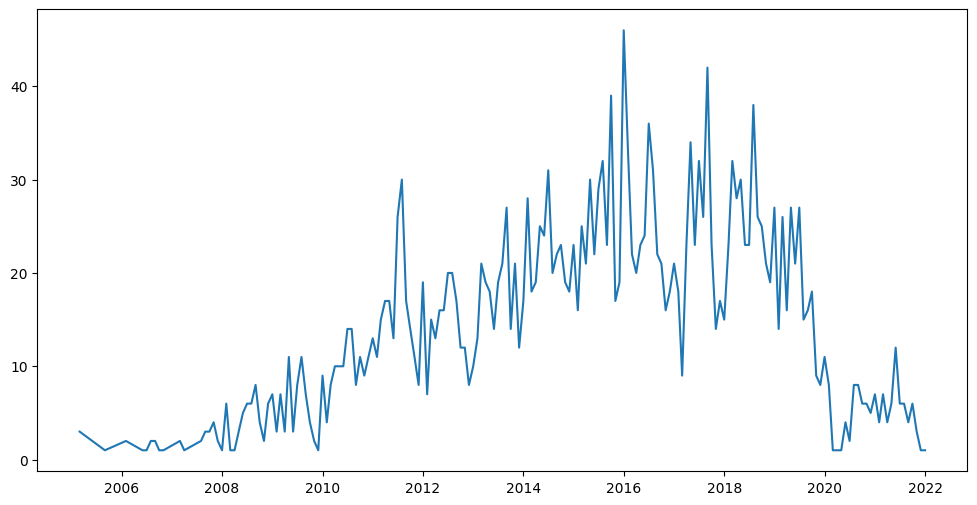

In [171]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(biz_df['date'], biz_df['review_count'], linestyle='-')

10:26:31 - cmdstanpy - INFO - Chain [1] start processing
10:26:31 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


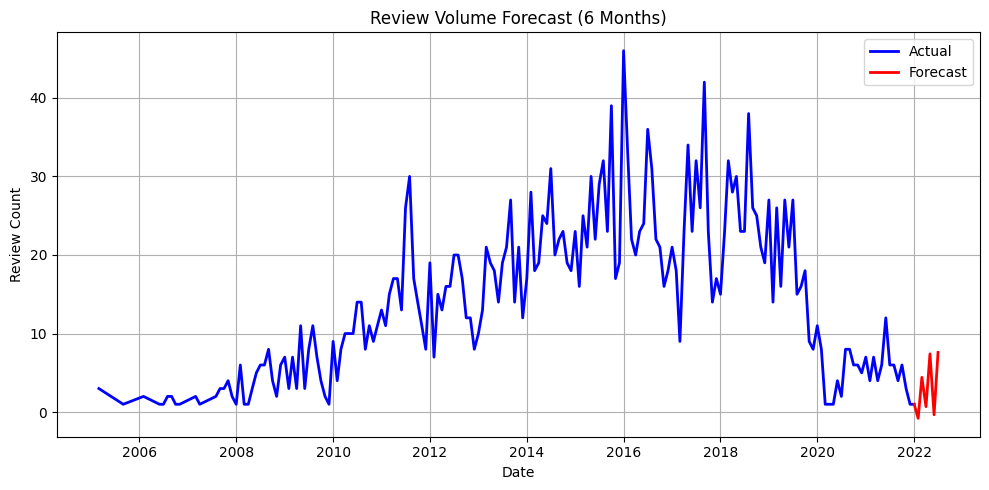

In [173]:
# Pick one business with enough reviews
top_business = review_ts['business_id'].value_counts().index[1]

biz_df = review_ts[review_ts['business_id'] == top_business].sort_values('date')


# Format data for Prophet
df_prophet = biz_df[['date', 'review_count']].rename(columns={'date': 'ds','review_count': 'y'})

# Fit the model
model = Prophet()
model.fit(df_prophet)

# Forecast 6 months into the future
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# Only grab forecast points beyond the last actual date
last_date = df_prophet['ds'].max()
future_forecast = forecast[forecast['ds'] > last_date]

'''# Plot the forecast
# Combine with actuals for plotting
plot_df = pd.concat([
    df_prophet.rename(columns={'y': 'value'}).assign(type='actual'),
    future_forecast[['ds', 'yhat']].rename(columns={'yhat': 'value'}).assign(type='forecast')
])

plt.figure(figsize=(10, 5))

# Plot actual
actual = plot_df[plot_df['type'] == 'actual']
plt.plot(actual['ds'], actual['value'], label='Actual', color='blue', linewidth=2)

# Plot forecast
forecast_part = plot_df[plot_df['type'] == 'forecast']
plt.plot(forecast_part['ds'], forecast_part['value'], label='Forecast', color='red', linestyle='-', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Review Count')
plt.title('Review Volume Forecast (6 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()'''


# Get last point of actuals
last_actual = df_prophet.iloc[-1][['ds', 'y']]
bridge_point = pd.DataFrame({
    'ds': [last_actual['ds']],
    'value': [last_actual['y']],
    'type': ['forecast']  # Label it forecast so it draws as part of red line
})

# Combine everything
forecast_part = future_forecast[['ds', 'yhat']].rename(columns={'yhat': 'value'}).assign(type='forecast')
forecast_part = pd.concat([bridge_point, forecast_part], ignore_index=True)

# Recombine with actuals
plot_df = pd.concat([
    df_prophet.rename(columns={'y': 'value'}).assign(type='actual'),
    forecast_part
])

# Plot
plt.figure(figsize=(10, 5))

# Actual
actual = plot_df[plot_df['type'] == 'actual']
plt.plot(actual['ds'], actual['value'], label='Actual', color='blue', linewidth=2)

# Forecast (with bridge point)
forecast_line = plot_df[plot_df['type'] == 'forecast']
plt.plot(forecast_line['ds'], forecast_line['value'], label='Forecast', color='red', linestyle='-', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Review Count')
plt.title('Review Volume Forecast (6 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [174]:
checkin

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."
...,...,...
131925,zznJox6-nmXlGYNWgTDwQQ,"2013-03-23 16:22:47, 2013-04-07 02:03:12, 2013..."
131926,zznZqH9CiAznbkV6fXyHWA,2021-06-12 01:16:12
131927,zzu6_r3DxBJuXcjnOYVdTw,"2011-05-24 01:35:13, 2012-01-01 23:44:33, 2012..."
131928,zzw66H6hVjXQEt0Js3Mo4A,"2016-12-03 23:33:26, 2018-12-02 19:08:45"


In [178]:
# Explode date field into individual rows
checkin = checkin.explode('date')

# If date field is still one big string of timestamps
checkin= checkin.assign(date=checkin['date'].str.split(', ')).explode('date')
checkin['date'] = pd.to_datetime(checkin['date'])

checkin

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,2020-03-13 21:10:56
0,---kPU91CF4Lq2-WlRu9Lw,2020-06-02 22:18:06
0,---kPU91CF4Lq2-WlRu9Lw,2020-07-24 22:42:27
0,---kPU91CF4Lq2-WlRu9Lw,2020-10-24 21:36:13
0,---kPU91CF4Lq2-WlRu9Lw,2020-12-09 21:23:33
...,...,...
131927,zzu6_r3DxBJuXcjnOYVdTw,2013-12-11 00:52:49
131927,zzu6_r3DxBJuXcjnOYVdTw,2013-12-13 00:58:14
131928,zzw66H6hVjXQEt0Js3Mo4A,2016-12-03 23:33:26
131928,zzw66H6hVjXQEt0Js3Mo4A,2018-12-02 19:08:45


In [181]:
# Group by business and month
checkin_ts = checkin.groupby(['business_id',checkin['date'].dt.to_period('M')]).size().reset_index(name='checkin_count')

# Convert period to timestamp
checkin_ts['date'] = checkin_ts['date'].dt.to_timestamp()

# Pick one business with lots of check-ins
top_checkin_biz = checkin_ts['business_id'].value_counts().index[0]

biz_checkin_df = checkin_ts[checkin_ts['business_id'] == top_checkin_biz].sort_values('date')


In [185]:
df_checkin_prophet = biz_checkin_df[['date', 'checkin_count']].rename(columns={
    'date': 'ds',
    'checkin_count': 'y'
})

model_checkin = Prophet()
model_checkin.fit(df_checkin_prophet)

future_checkins = model_checkin.make_future_dataframe(periods=24, freq='M')
forecast_checkin = model_checkin.predict(future_checkins)

10:31:57 - cmdstanpy - INFO - Chain [1] start processing


10:31:57 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


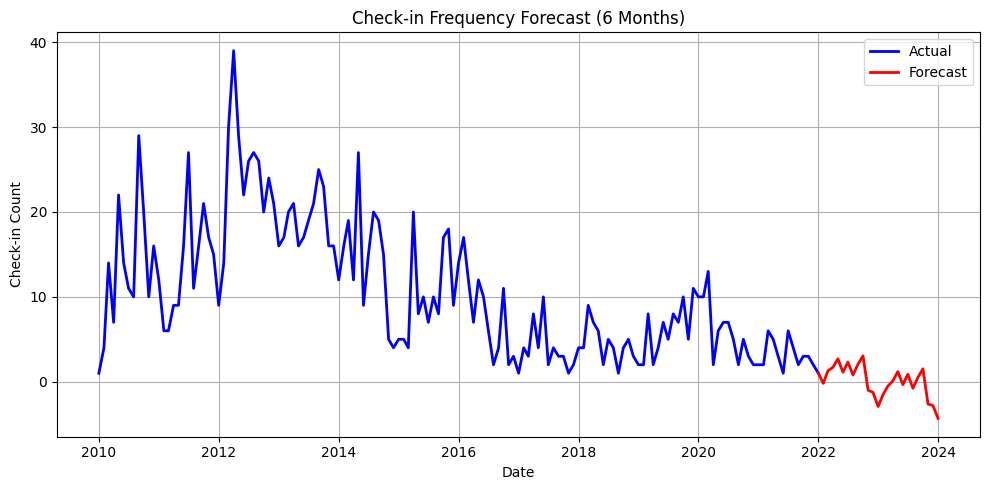

In [186]:
# Get last actual point
last_actual_ck = df_checkin_prophet.iloc[-1][['ds', 'y']]
bridge_ck = pd.DataFrame({
    'ds': [last_actual_ck['ds']],
    'value': [last_actual_ck['y']],
    'type': ['forecast']
})

# Format forecast values
forecast_part_ck = forecast_checkin[forecast_checkin['ds'] > last_actual_ck['ds']]
forecast_part_ck = forecast_part_ck[['ds', 'yhat']].rename(columns={'yhat': 'value'}).assign(type='forecast')
forecast_part_ck = pd.concat([bridge_ck, forecast_part_ck], ignore_index=True)

# Combine
plot_df_ck = pd.concat([
    df_checkin_prophet.rename(columns={'y': 'value'}).assign(type='actual'),
    forecast_part_ck
])

# Plot

plt.figure(figsize=(10, 5))

actual_ck = plot_df_ck[plot_df_ck['type'] == 'actual']
forecast_ck = plot_df_ck[plot_df_ck['type'] == 'forecast']

plt.plot(actual_ck['ds'], actual_ck['value'], label='Actual', color='blue', linewidth=2)
plt.plot(forecast_ck['ds'], forecast_ck['value'], label='Forecast', color='red', linestyle='-', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Check-in Count')
plt.title('Check-in Frequency Forecast (6 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
